In [1]:
# download dataset (UCI Default of Credit Card Clients)
import os
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
os.system("wget -O /content/default_credit.xls '{}'".format(url))


0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# If you downloaded XLS file
df = pd.read_excel('/content/default_credit.xls', header=1)
df.head()
df.shape


(30000, 25)

In [3]:
# Rename the target column to a simple name
df = df.rename(columns={'default payment next month': 'default'})

# Now define X and y
y = df['default']
X = df.drop(columns=['default'])


In [4]:
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Categorical columns: []


In [5]:
# Clean column names
df.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in df.columns]

# Print updated columns
print("Columns:", df.columns)

# Rename target column safely
if 'default_payment_next_month' in df.columns:
    df = df.rename(columns={'default_payment_next_month':'default'})
elif 'default_payment_next_month' not in df.columns and 'default_payment_next_month' in df.columns:
    df = df.rename(columns={'default payment next month':'default'})
elif 'default_payment_next_month' not in df.columns and 'default_payment_next_month' not in df.columns:
    df = df.rename(columns={'default_payment_next_month':'default'})

# Print final column names
print(df.columns)

y = df['default']
X = df.drop(columns=['default'])


Columns: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Identify types
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# Numeric pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# If NO categorical columns -> create empty transformer
if len(cat_cols) == 0:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols)
        ]
    )
else:
    from sklearn.preprocessing import OneHotEncoder
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

# Fit transform
X_proc = preprocessor.fit_transform(X)

# Feature names
processed_feature_names = num_cols.copy()

print("Processed shape:", X_proc.shape)
print("Feature names:", processed_feature_names)


Numeric: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Categorical: []
Processed shape: (30000, 24)
Feature names: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((22500, 24), (7500, 24))

In [10]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# XGBoost model
xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb.fit(X_train, y_train)

# RandomForest model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


def evaluate(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, probs)
    f1 = f1_score(y_test, preds)

    print(model.__class__.__name__)
    print("AUC:", round(auc,4))
    print("F1:", round(f1,4))
    print(classification_report(y_test, preds))

    return auc, f1


print("📌 XGBoost Results")
xgb_auc, xgb_f1 = evaluate(xgb, X_test, y_test)

print("\n📌 RandomForest Results")
rf_auc, rf_f1 = evaluate(rf, X_test, y_test)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:41:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📌 XGBoost Results
XGBClassifier
AUC: 0.7768
F1: 0.4699
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.65      0.37      0.47      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500


📌 RandomForest Results
RandomForestClassifier
AUC: 0.7746
F1: 0.4642
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.66      0.36      0.46      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [11]:
best_model = xgb if xgb_auc >= rf_auc else rf
print("Selected best model:", best_model.__class__.__name__)


Selected best model: XGBClassifier


Top Features: ['PAY_AMT6', 'PAY_AMT4', 'PAY_3', 'PAY_2', 'PAY_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_0']


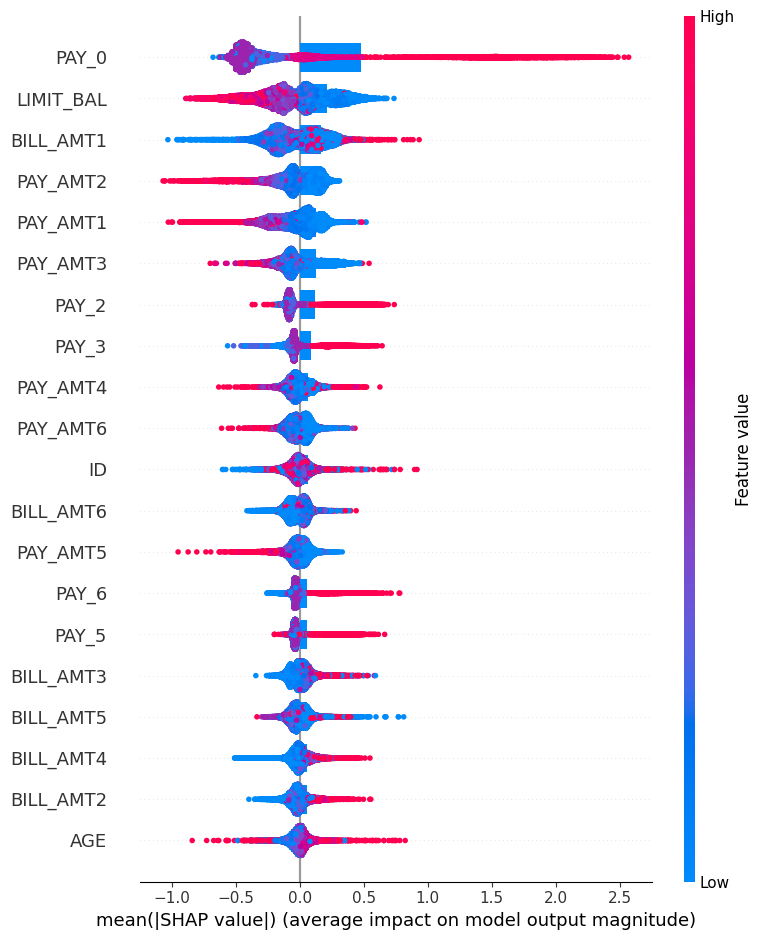

In [12]:
import shap
import matplotlib.pyplot as plt
import os

os.makedirs("plots", exist_ok=True)

# Use booster if XGBoost
if hasattr(best_model, "get_booster"):
    booster = best_model.get_booster()
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_train)
else:
    # TreeExplainer will work with RF too
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train)

# Summary Plot
shap.summary_plot(shap_values, X_train, feature_names=processed_feature_names, show=False)
plt.savefig("plots/global_shap_summary.png", dpi=300, bbox_inches='tight')

# Bar Plot
shap.summary_plot(shap_values, X_train, feature_names=processed_feature_names,
                  plot_type="bar", show=False)
plt.savefig("plots/global_shap_bar.png", dpi=300, bbox_inches='tight')

# Top features
mean_abs = np.mean(np.abs(shap_values), axis=0)
top_idx = np.argsort(mean_abs)[-10:]
top_features = [processed_feature_names[i] for i in top_idx]

print("Top Features:", top_features)


In [13]:
probs = best_model.predict_proba(X_test)[:,1]
preds = best_model.predict(X_test)

import numpy as np

# false negative (actual=1 but predicted=0)
fn_idx = np.where((y_test.values == 1) & (preds == 0))[0]

# false positive (actual=0 but predicted=1)
fp_idx = np.where((y_test.values == 0) & (preds == 1))[0]

# borderline correct prediction
border_idx = np.argsort(np.abs(probs - 0.5))

cases = {}
if len(fn_idx) > 0:
    cases['false_negative'] = fn_idx[0]
if len(fp_idx) > 0:
    cases['false_positive'] = fp_idx[0]

for i in border_idx:
    if preds[i] == y_test.values[i]:
        cases['borderline_correct'] = i
        break

cases


{'false_negative': np.int64(0),
 'false_positive': np.int64(17),
 'borderline_correct': np.int64(1835)}

In [14]:
for case, idx in cases.items():
    row = X_test[idx:idx+1]
    sv = explainer.shap_values(row)

    shap.force_plot(explainer.expected_value,
                    sv,
                    pd.DataFrame(row, columns=processed_feature_names),
                    matplotlib=True,
                    show=False)

    plt.savefig(f"plots/local_{case}.png", dpi=300, bbox_inches='tight')
    plt.clf()


In [15]:
# XGBoost
if hasattr(best_model, "get_booster"):
    xgb_imp = best_model.get_booster().get_score(importance_type='gain')
    print("XGBoost Gain Importance:", xgb_imp)

# SHAP top features
print("SHAP Top Features:", top_features)


XGBoost Gain Importance: {'f0': 3.9102723598480225, 'f1': 5.445621013641357, 'f2': 3.615750551223755, 'f3': 4.425228595733643, 'f4': 3.4536659717559814, 'f5': 3.834132194519043, 'f6': 84.85221099853516, 'f7': 35.183250427246094, 'f8': 23.217344284057617, 'f9': 9.127440452575684, 'f10': 9.72022819519043, 'f11': 7.699624061584473, 'f12': 5.1967902183532715, 'f13': 4.452111721038818, 'f14': 4.208849906921387, 'f15': 4.052804946899414, 'f16': 4.394917011260986, 'f17': 4.144880771636963, 'f18': 5.151126384735107, 'f19': 5.524263381958008, 'f20': 5.24761438369751, 'f21': 4.170966148376465, 'f22': 3.9408679008483887, 'f23': 4.108501434326172}
SHAP Top Features: ['PAY_AMT6', 'PAY_AMT4', 'PAY_3', 'PAY_2', 'PAY_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_0']


In [16]:
import joblib
joblib.dump(best_model, "best_model.pkl")


['best_model.pkl']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((22500, 24), (7500, 24))

In [18]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# XGBoost model
xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

# RandomForest model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


def evaluate(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, probs)
    f1 = f1_score(y_test, preds)

    print(model.__class__.__name__)
    print("AUC:", round(auc,4))
    print("F1:", round(f1,4))
    print(classification_report(y_test, preds))

    return auc, f1

print("XGBoost Results:")
xgb_auc, xgb_f1 = evaluate(xgb, X_test, y_test)

print("\nRandomForest Results:")
rf_auc, rf_f1 = evaluate(rf, X_test, y_test)


XGBoost Results:
XGBClassifier
AUC: 0.7768
F1: 0.4699
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.65      0.37      0.47      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500


RandomForest Results:
RandomForestClassifier
AUC: 0.7746
F1: 0.4642
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.66      0.36      0.46      1659

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [19]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("plots", exist_ok=True)

# XGBoost booster for SHAP
booster = xgb.get_booster()
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_train)

# Summary Plot
shap.summary_plot(shap_values, X_train, feature_names=processed_feature_names, show=False)
plt.savefig("plots/global_shap_summary.png", dpi=300, bbox_inches='tight')

# Bar Plot
shap.summary_plot(shap_values, X_train, feature_names=processed_feature_names,
                  plot_type="bar", show=False)
plt.savefig("plots/global_shap_bar.png", dpi=300, bbox_inches='tight')

# Top features
mean_abs = np.mean(np.abs(shap_values), axis=0)
top_idx = np.argsort(mean_abs)[-10:]
top_features = [processed_feature_names[i] for i in top_idx]

print("Top Features:", top_features)


Top Features: ['PAY_AMT6', 'PAY_AMT4', 'PAY_3', 'PAY_2', 'PAY_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_0']


In [20]:
probs = xgb.predict_proba(X_test)[:, 1]
preds = xgb.predict(X_test)

import numpy as np

# False Negative (actual=1, predicted=0)
fn_idx = np.where((y_test.values == 1) & (preds == 0))[0]

# False Positive (actual=0, predicted=1)
fp_idx = np.where((y_test.values == 0) & (preds == 1))[0]

# Borderline correct prediction
border_idx = np.argsort(np.abs(probs - 0.5))

cases = {}
if len(fn_idx) > 0:
    cases['false_negative'] = fn_idx[0]
if len(fp_idx) > 0:
    cases['false_positive'] = fp_idx[0]

# Select borderline only when correct
for i in border_idx:
    if preds[i] == y_test.values[i]:
        cases['borderline_correct'] = i
        break

cases


{'false_negative': np.int64(0),
 'false_positive': np.int64(17),
 'borderline_correct': np.int64(1835)}

In [21]:
for case, idx in cases.items():
    row = X_test[idx:idx+1]
    sv = explainer.shap_values(row)

    shap.force_plot(
        explainer.expected_value,
        sv,
        pd.DataFrame(row, columns=processed_feature_names),
        matplotlib=True,
        show=False
    )

    plt.savefig(f"plots/local_{case}.png", dpi=300, bbox_inches='tight')
    plt.clf()
